In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:
#Load the Image
image = cv2.imread("lane_image.jpg")
#image = cv2.imread("test.png")
image = image.astype('uint8')

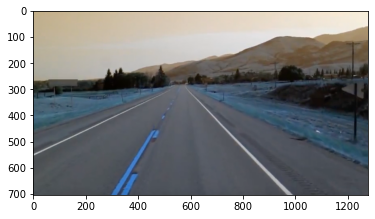

In [3]:
#Show Image
plt.imshow(image)

In [4]:
def detect_edges(img):
    """
    Input: image
    Return: preprocessed image
    """
    #Grayscale
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Blur image - gaussian filter
    blurred_image_gaussian = cv2.GaussianBlur(grayscale_image, (5,5),0)
    #Edge detection
    edges_gaussian = cv2.Canny(blurred_image_gaussian, 50, 100)
    return edges_gaussian

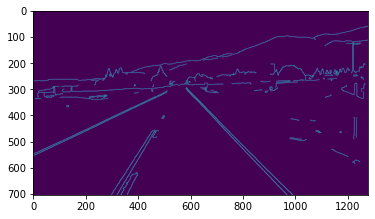

In [5]:
plt.imshow(detect_edges(image))

In [6]:
#height and width of image
image_height = image.shape[0]
image_width = image.shape[1]
def mask_image(image):
    """
    Mask the image for displaying only the area of interest
    Input: image
    Return: masked image 
    """
    #coordinates for masking the image
    coordinates = np.array([[(200, image_height), (550, 300), (600, 300), (1050, image_height)]])
    #create mask with zeros
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, coordinates, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

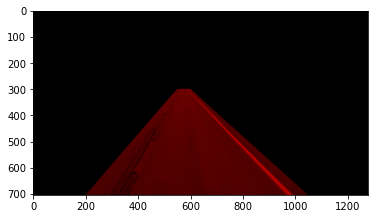

In [7]:
test = mask_image(image)
plt.imshow(test)

In [8]:
#function call
preprocessed_image = detect_edges(image)
masked_image = mask_image(preprocessed_image)

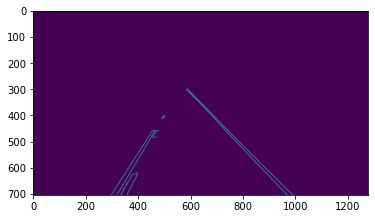

In [9]:
#plot the image
plt.imshow(masked_image)

In [10]:
def line_parameters(image, line):
    """
    Calculate the line coordinates for left and right "street-line"
    Input: Image, line = numpy ndarray
    Return: line coordinates as list()
    """
    if line.size == 1:
        return np.array([0,0,0,0])
    else:
        slope, intercept = line
        y1 = image.shape[0] 
        y2 = int(y1 * (3 / 5)) 
        x1 = int((y1 - intercept) / slope) 
        x2 = int((y2 - intercept) / slope) 
        return np.array([x1, y1, x2, y2])

In [11]:
def get_lines(image):
    """
    Hough line transformation to detect shapes (lines)
    Input: Image
    Return: numpy ndarray
    """
    lines = cv2.HoughLinesP(image, 2, np.pi / 180, 100,  np.array([]), minLineLength = 40,  maxLineGap = 5)  
    return lines

In [12]:
def compute_lines(lines, img):
    """
    Splits the detected lines of the Hough transformation into right and left line
    and calculate th average of them
    Input: lines - numpy ndarray, image
    Return: displayed calculated lines on the original image
    """
    right_line = []
    left_line = []
    
    #iterate over all values from hough transform and split it to x and y coordinates
    for i in range(lines.shape[0]):
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]
        x2 = lines[i][0][2]
        y2 = lines[i][0][3]
        #create a straight line equation
        parameter = np.polyfit((x1, x2), (y1,y2), 1)
        #split parameter from equation
        slope = parameter[0]
        intercept = parameter[1]
        #check if slope positive or negative
        
        if slope < 0:
            left_line.append((slope, intercept))
        else:
            right_line.append((slope, intercept))
        
    #average the positive and negative line to get only one line
    line_1_average = np.average(right_line, axis=0)
    line_2_average = np.average(left_line, axis=0)
    
    right_line_params = line_parameters(img, line_1_average)
    left_line_params = line_parameters(img, line_2_average)

    params = []
    params.append(right_line_params)
    params.append(left_line_params)
    return params

In [13]:
def display_lines(lines, img):
    """
    Display the computed lines on image
    Input: Image, lines = list()
    Return: Display lines
    """
    #Create empty image (black)
    line_image = np.zeros_like(img) 
    #iterate over all coordinates and display the lines
    if lines is not None:
        for x1, y1, x2, y2 in lines: 
            cv2.line(line_image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 10) 
    return line_image

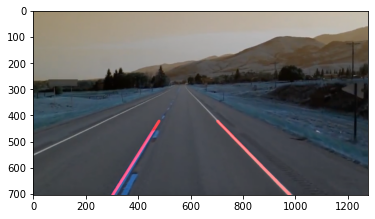

In [14]:
#Combine the function to get the task to work
edges = detect_edges(image)
masked_image = mask_image(edges)
lines = get_lines(masked_image)
computed_lines = compute_lines(lines, image)
line_image = display_lines(computed_lines, image)
#combine the original image with the computed lines
processed_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
plt.imshow(processed_image)

In [15]:
cap = cv2.VideoCapture("lane_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    edges = detect_edges(frame)
    masked_image = mask_image(edges)
    lines = get_lines(masked_image)
    computed_lines = compute_lines(lines, frame)
    line_image = display_lines(computed_lines, frame)
    processed_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.imshow("result", processed_image)
    #cv2.imshow("result", masked_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):       
        break
cap.release()
cv2.destroyAllWindows()

/Users/davidschaupp/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/davidschaupp/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
